In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import os

from Tools.config_helpers import loadConfig, make_small
from klepto.archives import dir_archive

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor, hist

from processor.trilep_ttZ_analysis import trilep_ttZ_analysis
from processor.default_accumulators import desired_output, add_processes_to_output, variations

In [42]:
# an equivalent code can be run with ipython -i trilep_ttZ_analysis.py within the processor directory

from Tools.samples import fileset_2018, fileset_2018_small

overwrite = True
year      = 2018
small     = True

# load the config and the cache
cfg = loadConfig()

cacheName = 'trilep_ttZ_analysis'
if small: cacheName += '_small'

cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)

fileset = {
    'topW_v3': fileset_2018['topW_v3'],
    'topW_EFT_cp8': fileset_2018['topW_EFT_cp8'],
    'topW_EFT_mix': fileset_2018['topW_EFT_mix'],
    'TTW': fileset_2018['TTW'],
    'TTZ': fileset_2018['TTZ'],
    'TTH': fileset_2018['TTH'],
    'diboson': fileset_2018['diboson'],
    'ttbar': fileset_2018['top2l'],
    'DY': fileset_2018['DY'],
}

fileset = make_small(fileset, small, n_max=1)  # run over just one file each if small is set to true

# add all processes to output so that the cutflow doesn't fail
add_processes_to_output(fileset, desired_output)

# add some histograms that we defined in the processor
# everything else is taken the default_accumulators.py
from processor.default_accumulators import mass_axis, dataset_axis, multiplicity_axis
desired_output.update({
    "dilep_mass": hist.Hist("Counts", dataset_axis, mass_axis),
    "N_SFOS": hist.Hist("Counts", dataset_axis, multiplicity_axis),
    "N_OSE": hist.Hist("Counts", dataset_axis, multiplicity_axis),
    "N_OSM": hist.Hist("Counts", dataset_axis, multiplicity_axis),
})

histograms = sorted(list(desired_output.keys()))

exe_args = {
    'workers': 16,
    'function_args': {'flatten': False},
    "schema": NanoAODSchema,
}
exe = processor.futures_executor

if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    print ("I'm running now")
    
    output = processor.run_uproot_job(
        fileset,
        "Events",
        trilep_ttZ_analysis(year=year, variations=variations, accumulator=desired_output),
        exe,
        exe_args,
        chunksize=250000,
    )
    
    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()

I'm running now


Processing:   0%|          | 0/12 [00:00<?, ?chunk/s]

Exception: Failed processing file: /hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.3/ProjectMetis_TTWminusJetsToLNuEWK_5f_NLO_v2_RunIIAutumn18_NANO_v4/nanoSkim_1.root (0-58724)

In [ ]:
# we can just take the process list from the fileset to avoid any confusions
processes = list(fileset.keys())

processes.remove('topW_EFT_cp8')
processes.remove('topW_EFT_mix')

# the following list is directly taken from Tools/ttZ_selection.py
lines = ['entry']
lines += [
            'filter',
            'lepveto',
            'trilep',
            'p_T(lep0)>25',
            'p_T(lep1)>20',
            'trigger',
            'offZ',
            'MET>50',
            'N_jet>2',
            'N_central>1',
            'N_btag>0',
            'N_fwd>0',
        ]

lines += [
            'SFOSveto',
        ]

from Tools.helpers import getCutFlowTable
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, signal='topW_v3')
df

In [ ]:
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, absolute=False, signal='topW_v3')
df

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

from plots.helpers import makePlot

# defining some new axes for rebinning.
N_bins = hist.Bin('multiplicity', r'$N$', 10, -0.5, 9.5)
N_bins_red = hist.Bin('multiplicity', r'$N$', 5, -0.5, 4.5)
mass_bins = hist.Bin('mass', r'$M\ (GeV)$', 20, 0, 200)
pt_bins = hist.Bin('pt', r'$p_{T}\ (GeV)$', 30, 0, 300)
pt_bins_coarse = hist.Bin('pt', r'$p_{T}\ (GeV)$', 10, 0, 300)
eta_bins = hist.Bin('eta', r'$\eta $', 25, -5.0, 5.0)

my_labels = {
    'topW_v3': 'top-W scat.',
    'topW_EFT_cp8': 'EFT, cp8',
    'topW_EFT_mix': 'EFT mix',
    'TTZ': r'$t\bar{t}Z$',
    'TTW': r'$t\bar{t}W$',
    'TTH': r'$t\bar{t}H$',
    'diboson': 'VV/VVV',
    'ttbar': r'$t\bar{t}$',
    'DY': 'Drell-Yan',
}

my_colors = {
    'topW_v3': '#FF595E',
    'topW_EFT_cp8': '#000000',
    'topW_EFT_mix': '#0F7173',
    'TTZ': '#FFCA3A',
    'TTW': '#8AC926',
    'TTH': '#34623F',
    'diboson': '#525B76',
    'ttbar': '#1982C4',
    'DY': '#6A4C93',}

In [ ]:
makePlot(output, 'lead_lep', 'pt',
         data=[],
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}$ (lead lep) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['diboson', 'TTW', 'TTH', 'TTZ', 'ttbar'],
         signals=['topW_v3', 'topW_EFT_cp8', 'topW_EFT_mix'],
        )

In [ ]:
makePlot(output, 'lead_lep', 'pt',
         data=[],
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}$ (lead lep) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

In [ ]:
makePlot(output, 'lead_lep', 'pt',
         data=[],
         shape=True,
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}$ (lead lep) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

In [ ]:
makePlot(output, 'lead_lep', 'pt',
         data=[],
         shape=True,
         bins=pt_bins_coarse, log=True, normalize=False, axis_label=r'$p_{T}$ (lead lep) (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         omit=['DY', 'ttbar', 'TTZ', 'TTH', 'diboson'],
        )

In [ ]:
makePlot(output, 'dilep_mass', 'mass',
         bins=mass_bins, log=False, normalize=False, axis_label=r'$M_{\ell\ell}$ (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson',  'TTW', 'TTH', 'TTZ', 'ttbar', 'DY'],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )
makePlot(output, 'dilep_mass', 'mass',
         shape=True,
         bins=mass_bins, log=False, normalize=False, axis_label=r'$M_{\ell\ell}$ (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         ymax=0.7,
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

In [ ]:
makePlot(output, 'N_SFOS', 'multiplicity', 
         data=[],
         bins=hist.Bin('multiplicity', r'$N$', 2, -0.5, 1.5), log=True, normalize=False, axis_label='Same Flavour Opposite Sign',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )

The ttZ process shouldn't be present in the N=0 bin because the Z decay will always produce a SFOS pair. ttWq should be in the N=0 bin, as well as the N=1 bin

In [ ]:
#output["N_SFOS"].values()

In [ ]:
'''makePlot(output, 'N_OSE', 'multiplicity',
         data=[],
         bins=hist.Bin('multiplicity', r'$N$', 2, -0.5, 1.5), log=True, normalize=False, axis_label='Same Flavour Opposite Sign',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )'''

In [15]:
'''makePlot(output, 'N_OSM', 'multiplicity',
         data=[],
         bins=hist.Bin('multiplicity', r'$N$', 2, -0.5, 1.5), log=True, normalize=False, axis_label='Same Flavour Opposite Sign',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'ttbar'],
         signals=[],
         omit=['topW_EFT_cp8', 'topW_EFT_mix'],
        )'''

"makePlot(output, 'N_OSM', 'multiplicity',\n         data=[],\n         bins=hist.Bin('multiplicity', r'$N$', 2, -0.5, 1.5), log=True, normalize=False, axis_label='Same Flavour Opposite Sign',\n         new_colors=my_colors, new_labels=my_labels,\n         order=['topW_v3', 'diboson', 'TTW', 'TTH', 'TTZ', 'ttbar'],\n         signals=[],\n         omit=['topW_EFT_cp8', 'topW_EFT_mix'],\n        )"

Try Loading in a single file

In [53]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import Weights, PackedSelection

import awkward as ak
import numpy as np

from Tools.objects import *
from Tools.basic_objects import *
from Tools.cutflow import *
from Tools.config_helpers import loadConfig, make_small
from Tools.triggers import *
from Tools.btag_scalefactors import *
#from Tools.lepton_scalefactors import *
from Tools.selections import Selection

# the below command will change to .from_root in coffea v0.7.0
#events = NanoEventsFactory.from_root('/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.3/ProjectMetis_TTWJetsToLNuEWK_5f_NLO_RunIIAutumn18_NANO_v2/nanoSkim_1.root', schemaclass=NanoAODSchema).events()
events = NanoEventsFactory.from_root('/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.3/TTZToLLNuNu_M-10_TuneCP5_13TeV-amcatnlo-pythia8_RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21_ext1-v1/nanoSkim_1.root', schemaclass=NanoAODSchema).events()

In [54]:
muon     = Collections(events, "Muon", "vetoTTH").get()
electron     = Collections(events, "Electron", "vetoTTH").get()

In [55]:
dimuon = choose(muon,2)
OS_dimuon = dimuon[(dimuon['0'].charge*dimuon['1'].charge < 0)]

dielectron = choose(electron)
OS_dielectron = dielectron[(dielectron['0'].charge*dielectron['1'].charge < 0)]

In [56]:
e=ak.num(OS_dielectron)

m = ak.num(OS_dimuon)

if ak.any(m) ==1:
    print('yay')

yay


In [57]:
print(OS_dielectron)

[[], [], [], [], [], [], ... t: 86.1, charge: 0, '0': Electron, '1': Electron}], []]


In [58]:
print(OS_dielectron[ak.num(electron)>=3])

[[{x: 83.1, y: 158, z: -166, t: 260, charge: 0, ... '0': Electron, '1': Electron}]]


In [59]:
lepton = (ak.num(electron)+ak.num(muon))>=3
ak.num(OS_dielectron[(lepton)])

<Array [0, 2, 0, 0, 2, 2, ... 0, 0, 0, 0, 2, 2] type='113761 * int64'>

In [60]:
ak.num(OS_dimuon[(lepton)])

<Array [1, 0, 2, 1, 0, 0, ... 1, 1, 1, 2, 0, 0] type='113761 * int64'>

In [61]:
x = ak.num(OS_dielectron[(lepton)])+ak.num(OS_dimuon[(lepton)])
x

<Array [1, 2, 2, 1, 2, 2, ... 1, 1, 1, 2, 2, 2] type='113761 * int64'>

(array([3.8280e+03, 4.8667e+04, 5.6787e+04, 8.4100e+02, 0.0000e+00,
        3.5560e+03, 3.0000e+00, 7.7000e+01, 1.0000e+00, 1.0000e+00]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

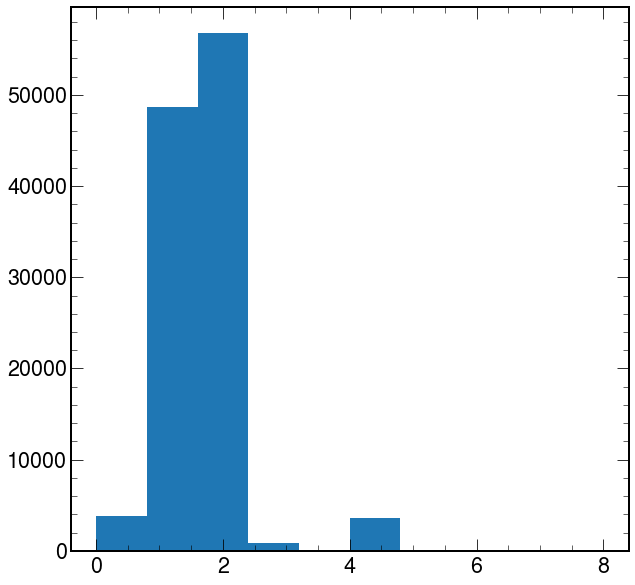

In [63]:
plt.hist(x)